In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import shutil

# Import Data

In [ ]:
base_dirs = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]
output_dir = r"Emotions"

os.makedirs(output_dir, exist_ok=True)

pattern = re.compile(
    r"(?P<modality>\d{2})-(?P<vocal_channel>\d{2})-(?P<emotion>\d{2})-(?P<intensity>\d{2})-(?P<statement>\d{2})-(?P<repetition>\d{2})-(?P<actor>\d{2})\.wav"
)

emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

for base_dir in base_dirs:
    for actor_folder in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor_folder)
        if not os.path.isdir(actor_path):
            continue
        
        for file_name in os.listdir(actor_path):
            match = pattern.match(file_name)
            if not match:
                continue
            
            emotion_code = match.group("emotion")
            emotion = emotion_labels.get(emotion_code, "unknown")
            
            emotion_path = os.path.join(output_dir, emotion)
            os.makedirs(emotion_path, exist_ok=True)
            
            src = os.path.join(actor_path, file_name)
            dst = os.path.join(emotion_path, file_name)
            shutil.copy2(src, dst)



In [ ]:
import os
import pandas as pd


modality = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
vocal_channel = {'01': 'speech', '02': 'song'}
emotion = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
intensity = {'01': 'normal', '02': 'strong'}
statement = {'01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'}
repetition = {'01': '1st repetition', '02': '2nd repetition'}


base_path = "Emotions"

data = []


for emotion_folder in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion_folder)
    if not os.path.isdir(emotion_path):
        continue
    
    for filename in os.listdir(emotion_path):
        if not filename.lower().endswith('.wav'):
            continue
        
        parts = filename.split('.')[0].split('-')
        if len(parts) != 7:
            continue
        
        file_info = {
            'Filename': filename,
            'Filepath': os.path.join(emotion_path, filename),
            'Modality': modality.get(parts[0]),
            'Vocal Channel': vocal_channel.get(parts[1]),
            'Emotion': emotion.get(parts[2]),
            'Intensity': intensity.get(parts[3]),
            'Statement': statement.get(parts[4]),
            'Repetition': repetition.get(parts[5]),
            'Actor': int(parts[6]),
            'Gender': 'male' if int(parts[6]) % 2 == 1 else 'female'
        }
        data.append(file_info)

df = pd.DataFrame(data)
print(df.head())
print(f"\n✅ Total files loaded: {len(df)}")


                   Filename                                 Filepath  \
0  03-01-05-01-01-01-01.wav  Emotions\angry\03-01-05-01-01-01-01.wav   
1  03-01-05-01-01-01-02.wav  Emotions\angry\03-01-05-01-01-01-02.wav   
2  03-01-05-01-01-01-03.wav  Emotions\angry\03-01-05-01-01-01-03.wav   
3  03-01-05-01-01-01-04.wav  Emotions\angry\03-01-05-01-01-01-04.wav   
4  03-01-05-01-01-01-05.wav  Emotions\angry\03-01-05-01-01-01-05.wav   

     Modality Vocal Channel Emotion Intensity                     Statement  \
0  audio-only        speech   angry    normal  Kids are talking by the door   
1  audio-only        speech   angry    normal  Kids are talking by the door   
2  audio-only        speech   angry    normal  Kids are talking by the door   
3  audio-only        speech   angry    normal  Kids are talking by the door   
4  audio-only        speech   angry    normal  Kids are talking by the door   

       Repetition  Actor  Gender  
0  1st repetition      1    male  
1  1st repetition     

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Filename       2452 non-null   object
 1   Filepath       2452 non-null   object
 2   Modality       2452 non-null   object
 3   Vocal Channel  2452 non-null   object
 4   Emotion        2452 non-null   object
 5   Intensity      2452 non-null   object
 6   Statement      2452 non-null   object
 7   Repetition     2452 non-null   object
 8   Actor          2452 non-null   int64 
 9   Gender         2452 non-null   object
dtypes: int64(1), object(9)
memory usage: 191.7+ KB


# EDA

In [5]:
df.isnull().sum()

Filename         0
Filepath         0
Modality         0
Vocal Channel    0
Emotion          0
Intensity        0
Statement        0
Repetition       0
Actor            0
Gender           0
dtype: int64

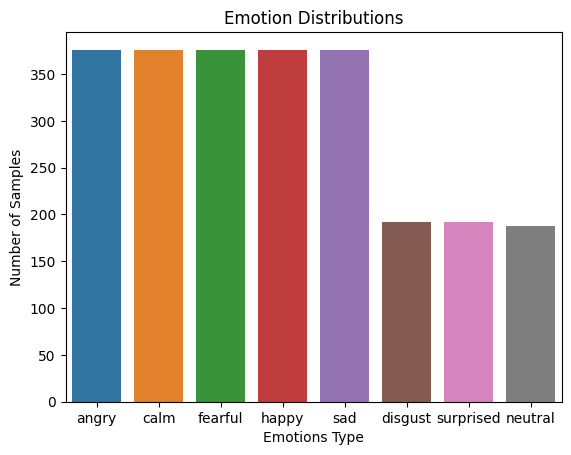

In [6]:
plt.Figure(figsize=(10,5))
sns.countplot(x='Emotion', data=df, order=df['Emotion'].value_counts().index)
plt.title('Emotion Distributions')
plt.xlabel('Emotions Type')
plt.ylabel('Number of Samples')
plt.show()

In [7]:
emotions_count = df['Emotion'].value_counts(normalize=True) * 100

print(emotions_count.round(2))

Emotion
angry        15.33
calm         15.33
fearful      15.33
happy        15.33
sad          15.33
disgust       7.83
surprised     7.83
neutral       7.67
Name: proportion, dtype: float64


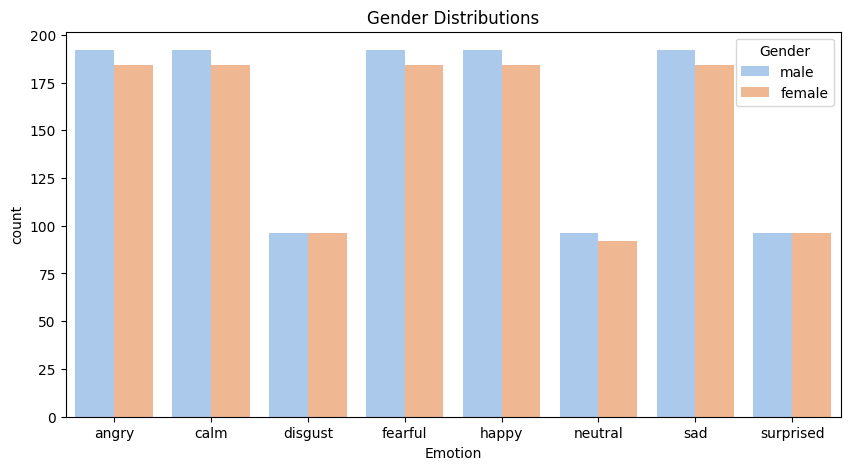

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotion', hue='Gender' ,data=df, palette='pastel')
plt.title('Gender Distributions')
plt.show()

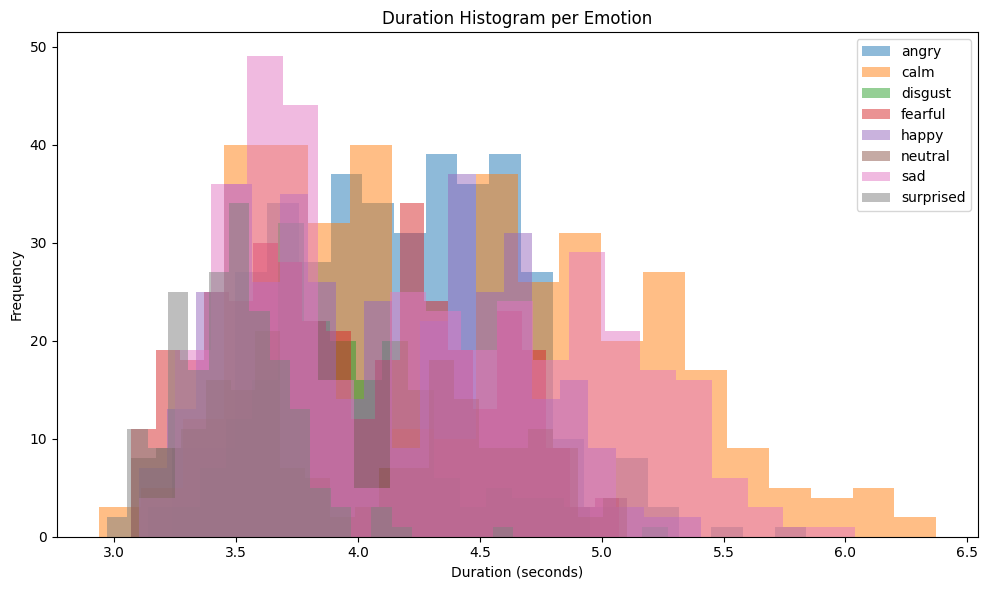

In [9]:
import librosa

durations = []
for filepath in df["Filepath"]:
    try:
        duration = librosa.get_duration(path=filepath)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        duration = None
    durations.append(duration)

df["Duration"] = durations

plt.figure(figsize=(10, 6))
for emotion in df["Emotion"].unique():
    subset = df[df["Emotion"] == emotion]
    plt.hist(subset["Duration"], bins=20, alpha=0.5, label=emotion)
plt.title("Duration Histogram per Emotion")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Preprocessing

In [10]:
import seaborn as sns
import librosa, librosa.display
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
df['Actor'] = df['Actor'].astype(int)
df['path'] = df.apply(lambda r: os.path.join(base_path, f"Actor_{int(r['Actor']):02d}", r['Filename']), axis=1)

print("Total Files: ", len(df))
print(df['Emotion'].value_counts())
print(df[['Actor', 'Gender']].value_counts())

Total Files:  2452
Emotion
angry        376
calm         376
fearful      376
happy        376
sad          376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
Actor  Gender
1      male      104
2      female    104
23     male      104
22     female    104
21     male      104
20     female    104
19     male      104
17     male      104
16     female    104
15     male      104
14     female    104
13     male      104
12     female    104
11     male      104
10     female    104
9      male      104
8      female    104
7      male      104
6      female    104
5      male      104
4      female    104
3      male      104
24     female    104
18     female     60
Name: count, dtype: int64


In [12]:
df.drop(columns=['path'])

,Filename,Filepath,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,Gender,Duration
0,03-01-05-01-01-01-01.wav,Emotions\angry\03-01-05-01-01-01-01.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,1,male,3.870542
1,03-01-05-01-01-01-02.wav,Emotions\angry\03-01-05-01-01-01-02.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,2,female,3.670333
2,03-01-05-01-01-01-03.wav,Emotions\angry\03-01-05-01-01-01-03.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,3,male,4.004000
3,03-01-05-01-01-01-04.wav,Emotions\angry\03-01-05-01-01-01-04.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,4,female,3.703708
4,03-01-05-01-01-01-05.wav,Emotions\angry\03-01-05-01-01-01-05.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,5,male,3.870542
...,...,...,...,...,...,...,...,...,...,...,...
2447,03-01-08-02-02-02-20.wav,Emotions\surprised\03-01-08-02-02-02-20.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,20,female,3.436771
2448,03-01-08-02-02-02-21.wav,Emotions\surprised\03-01-08-02-02-02-21.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,21,male,3.536875
2449,03-01-08-02-02-02-22.wav,Emotions\surprised\03-01-08-02-02-02-22.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,22,female,3.636958
2450,03-01-08-02-02-02-23.wav,Emotions\surprised\03-01-08-02-02-02-23.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,23,male,3.303292


In [ ]:
SR = 16000
N_Mels = 128
Target_Width = 128


def load_audio(path, sr=SR):
    y, _ = librosa.load(path, sr=sr)
    y, _ = librosa.effects.trim(y)
    return y

def wav_to_mel(path, sr=SR, n_mels=N_Mels, target_width=Target_Width):
    try:
        y = load_audio(path, sr)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    if S_db.shape[1] < target_width:
        pad_width = target_width - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        S_db = S_db[:, :target_width]

    S_Norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-6)

    img = S_Norm.astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3

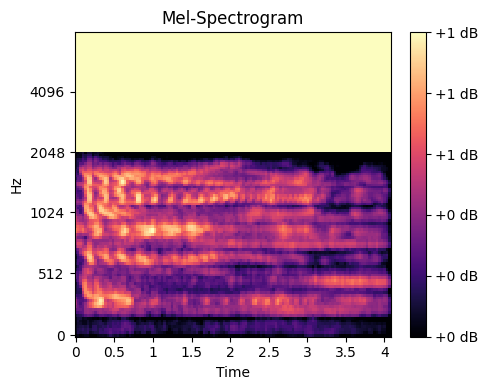

In [14]:
sample_img = wav_to_mel(df.iloc[0]['Filepath'])
plt.figure(figsize=(5, 4))
librosa.display.specshow(
    sample_img[:, :, 0].T,
    sr=SR,
    x_axis='time',
    y_axis='mel'
)
plt.title("Mel-Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm

labels = df['Emotion'].values
le = LabelEncoder()
y_all = le.fit_transform(labels)
num_classes = len(le.classes_)

print("Classes:", le.classes_)
print("Number of classes:", num_classes)

x_list = []
y_list = []

for p, lab in tqdm(zip(df['Filepath'], y_all), total=len(df)):
    img = wav_to_mel(p)
    if img is None:
        continue
    x_list.append(img)
    y_list.append(lab)


x = np.stack(x_list)
y = np.array(y_list)

print("✅ Done!")
print("x shape:", x.shape)
print("y shape:", y.shape)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Number of classes: 8


100%|██████████| 2452/2452 [00:17<00:00, 138.04it/s]


✅ Done!
x shape: (2452, 128, 128, 3)
y shape: (2452,)


# Data Splitting and Augmentation

In [16]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

print(x_train.shape, x_val.shape, x_test.shape)

(1961, 128, 128, 3) (245, 128, 128, 3) (246, 128, 128, 3)


In [17]:
def add_noise(y, noise_factor = 0.005):
  noise = np.random(len(y))
  return y + noise_factor * noise

def pitch_shift(y, sr, n_steps = 2):
  return librosa.effects.pitch_shift(y, sr, n_steps)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)

datagen.fit(x_train)

# <b>Transfer Learning</b> (ResNet50)

## Load Pre-trained Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History


base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(Target_Width, Target_Width, 3)
)
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    validation_data=(x_val, y_val),
    epochs=2
)


train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print("✅ Training done")


Epoch 1/2
123/123 [==============================] - 15s 48ms/step - loss: 2.1054 - accuracy: 0.1601 - val_loss: 2.0261 - val_accuracy: 0.2245
Epoch 2/2
123/123 [==============================] - 5s 38ms/step - loss: 2.0742 - accuracy: 0.1566 - val_loss: 2.0149 - val_accuracy: 0.2122
✅ Training done


In [ ]:
model_pretrained = model
model_pretrained.save('model_pretrained.h5')

## Fine Tuning

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


base_model.trainable = True

print("Trainable layers:", sum([l.trainable for l in base_model.layers]))


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=32,
    restore_best_weights=True
)


fine_history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    validation_data=(x_val, y_val),
    epochs=32,
    callbacks=[early_stop]
)


fine_train_acc = fine_history.history['accuracy']
fine_val_acc = fine_history.history['val_accuracy']
fine_train_loss = fine_history.history['loss']
fine_val_loss = fine_history.history['val_loss']

print("✅ Fine-tuning done")


Trainable layers: 175
Epoch 1/32
123/123 [==============================] - 16s 72ms/step - loss: 1.8858 - accuracy: 0.2958 - val_loss: 2.6191 - val_accuracy: 0.1510
Epoch 2/32
123/123 [==============================] - 7s 59ms/step - loss: 1.5296 - accuracy: 0.4187 - val_loss: 2.4994 - val_accuracy: 0.1510
Epoch 3/32
123/123 [==============================] - 7s 59ms/step - loss: 1.3371 - accuracy: 0.4901 - val_loss: 2.6145 - val_accuracy: 0.1510
Epoch 4/32
123/123 [==============================] - 8s 61ms/step - loss: 1.2410 - accuracy: 0.5421 - val_loss: 2.1650 - val_accuracy: 0.1551
Epoch 5/32
123/123 [==============================] - 8s 61ms/step - loss: 1.1258 - accuracy: 0.5752 - val_loss: 2.1344 - val_accuracy: 0.2122
Epoch 6/32
123/123 [==============================] - 7s 61ms/step - loss: 1.0679 - accuracy: 0.6043 - val_loss: 2.9456 - val_accuracy: 0.2163
Epoch 7/32
123/123 [==============================] - 8s 61ms/step - loss: 0.9596 - accuracy: 0.6548 - val_loss: 2.3229

In [ ]:
model_finetuned = model
model_finetuned.save('model_finetuned.h5')

## Evaluation

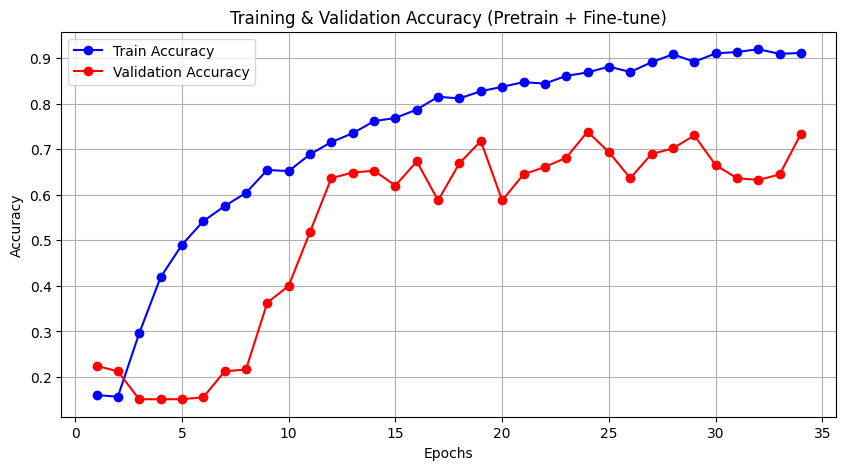

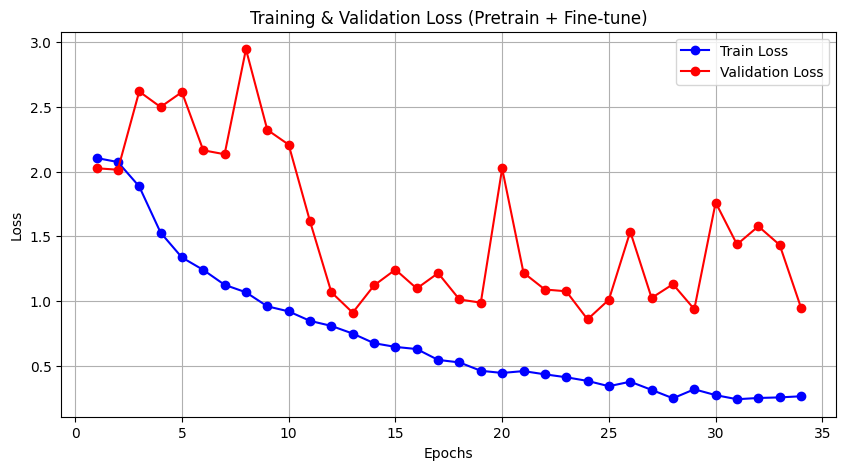

In [ ]:
import matplotlib.pyplot as plt


all_train_acc = train_acc + fine_train_acc
all_val_acc = val_acc + fine_val_acc
all_train_loss = train_loss + fine_train_loss
all_val_loss = val_loss + fine_val_loss

epochs = range(1, len(all_train_acc)+1)


plt.figure(figsize=(10,5))
plt.plot(epochs, all_train_acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, all_val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Pretrain + Fine-tune)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(epochs, all_train_loss, 'bo-', label='Train Loss')
plt.plot(epochs, all_val_loss, 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss (Pretrain + Fine-tune)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np


test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)


class_names = le.classes_
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)


Test Loss: 1.081499457359314
Test Accuracy: 0.7317073345184326
8/8 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

       angry       0.80      0.87      0.84        38
        calm       0.84      0.73      0.78        37
     disgust       0.88      0.74      0.80        19
     fearful       0.75      0.71      0.73        38
       happy       0.80      0.53      0.63        38
     neutral       0.48      0.84      0.62        19
         sad       0.61      0.74      0.67        38
   surprised       0.88      0.79      0.83        19

    accuracy                           0.73       246
   macro avg       0.76      0.74      0.74       246
weighted avg       0.76      0.73      0.73       246



8/8 [==============================] - 1s 24ms/step


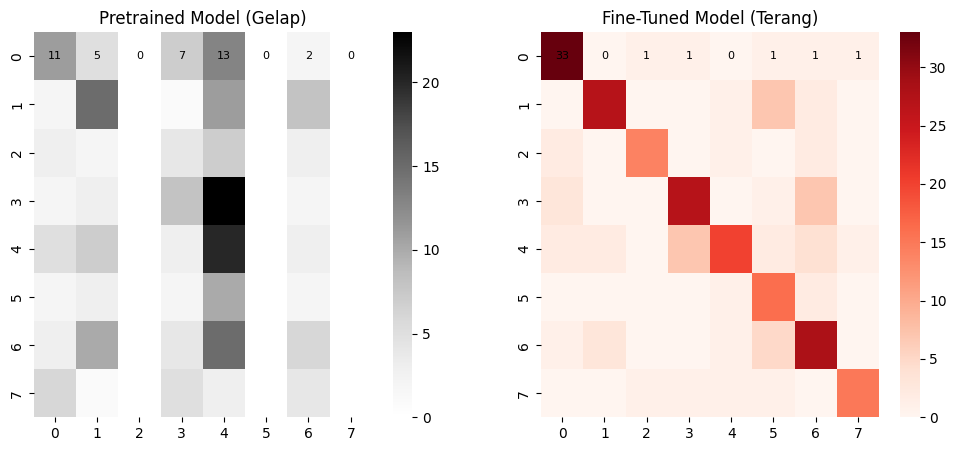

In [ ]:
from tensorflow.keras.models import load_model

model_pretrained = load_model('model_pretrained.h5')
model_finetuned = load_model('model_finetuned.h5')


y_pred_pre = model_pretrained.predict(x_test)
y_pred_pre = y_pred_pre.argmax(axis=1)

y_pred_fine = model_finetuned.predict(x_test)
y_pred_fine = y_pred_fine.argmax(axis=1)


from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_pre = confusion_matrix(y_test, y_pred_pre)
cm_fine = confusion_matrix(y_test, y_pred_fine)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(
    cm_pre, 
    annot=True, fmt=".0f", cmap="Greys", cbar=True,
    annot_kws={"size": 8, "color": "black"}  # warna angka
)
plt.title("Pretrained Model (Gelap)")

plt.subplot(1,2,2)
sns.heatmap(
    cm_fine, 
    annot=True, fmt=".0f", cmap="Reds", cbar=True,
    annot_kws={"size": 8, "color": "black"}
)
plt.title("Fine-Tuned Model (Terang)")
plt.show()
